In [6]:
#IMPORT NECESSARY PACKAGES
import pandas as pd
import os
import pickle
import CO2_functions
from CO2_functions import *
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np

In [21]:
import importlib
importlib.reload(CO2_functions)
from CO2_functions import *

In [17]:
date1,date2 = get_date_range()
Vent_Anem_Temp = get_vent_anem_temp_data('Aug2019_Vent_Anem_Temp',date1,date2)
Picarro = get_picarro_data('Aug2019_Picarro',date1,date2,'spikes','concat',0)
LI_vent = get_LI_data('Aug2019_LI_8100_Vent',date1,date2)
Multiplexer = get_multiplexer_data('Aug2019_Multiplexer',date1,date2,'concat',0)

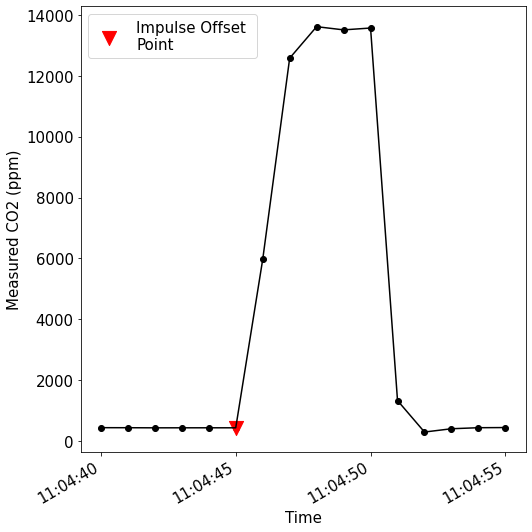

In [128]:
df = LI_vent
dt1 = '2019-11-27 11:04:40'
dt2 = '2019-11-27 11:04:55'

df1 = df.loc[(df['Local_DT']>=dt1)&(df['Local_DT']<=dt2)].reset_index(drop = True)

labsize = 15
fig,ax = plt.subplots(figsize = [7.5,7.5])

x_pl = 'Local_DT'
y_pl = 'LI_CO2'
ax.scatter(df1[x_pl],df1[y_pl],color = 'black')
ax.plot(df1[x_pl],df1[y_pl],color = 'black')

idx = 5
ax.scatter(df1[x_pl][idx],df1[y_pl][idx],color = 'red',marker = 'v',s = 200,label = 'Impulse Offset \nPoint')

ax.set_xlabel('Time',size=labsize)
ax.set_ylabel('Measured CO2 (ppm)',size=labsize)
ax.tick_params(axis='both', which='major', labelsize=labsize)
ax.legend(fontsize = labsize,loc = 2)

plt.gcf().autofmt_xdate()
fig.tight_layout()
plt.show()


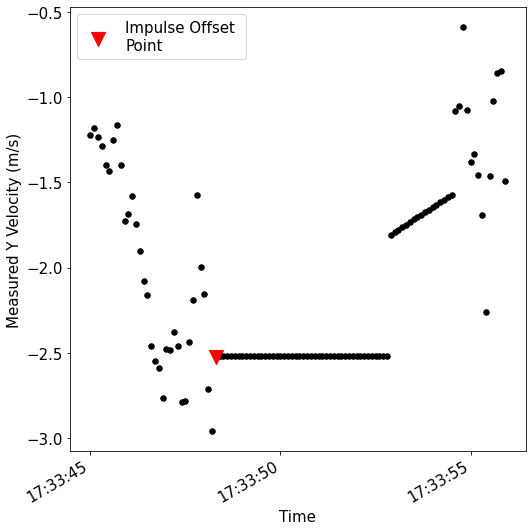

In [127]:
df = Picarro
dt1 = '2019-11-27 10:33:45'
dt2 = '2019-11-27 10:33:55'

df1 = df.loc[(df['Local_DT']>=dt1)&(df['Local_DT']<=dt2)].reset_index(drop = True)
df1['Local_DT'] = pd.to_datetime(df1['EPOCH_TIME'],unit = 's')

labsize = 15
fig,ax = plt.subplots(figsize = [7.5,7.5])

x_pl = 'Local_DT'
y_pl = 'ANEM_Y'
ax.scatter(df1[x_pl],df1[y_pl],color = 'black',s = 30)
#ax.plot(df1[x_pl],df1[y_pl],color = 'black')

idx = 33
ax.scatter(df1[x_pl][idx],df1[y_pl][idx],color = 'red',marker = 'v',s = 200,label = 'Impulse Offset \nPoint')

ax.set_xlabel('Time',size=labsize)
ax.set_ylabel('Measured Y Velocity (m/s)',size=labsize)
ax.tick_params(axis='both', which='major', labelsize=labsize)
ax.legend(fontsize = labsize,loc = 2)

plt.gcf().autofmt_xdate()
fig.tight_layout()
plt.show()


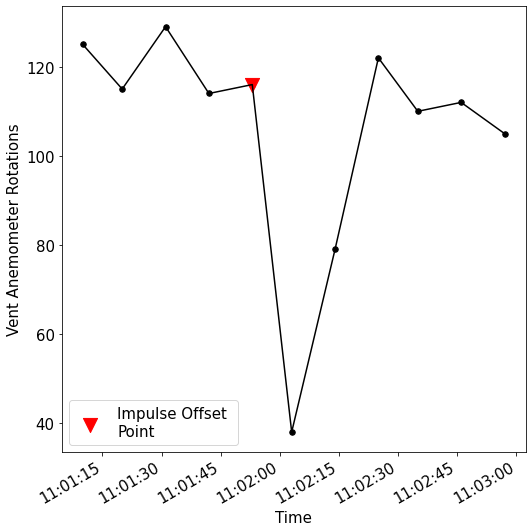

In [126]:
df = Vent_Anem_Temp
dt1 = '2019-11-27 11:01:00'
dt2 = '2019-11-27 11:03:00'

df1 = df.loc[(df['Local_DT']>=dt1)&(df['Local_DT']<=dt2)].reset_index(drop = True)

labsize = 15
fig,ax = plt.subplots(figsize = [7.5,7.5])

x_pl = 'Local_DT'
y_pl = 'Rotations'
ax.scatter(df1[x_pl],df1[y_pl],color = 'black',s = 30)
ax.plot(df1[x_pl],df1[y_pl],color = 'black')

idx = 4
ax.scatter(df1[x_pl][idx],df1[y_pl][idx],color = 'red',marker = 'v',s = 200,label = 'Impulse Offset \nPoint')

ax.set_xlabel('Time',size=labsize)
ax.set_ylabel('Vent Anemometer Rotations',size=labsize)
ax.tick_params(axis='both', which='major', labelsize=labsize)
ax.legend(fontsize = labsize,loc = 3)

plt.gcf().autofmt_xdate()
fig.tight_layout()
plt.show()


# DRIFT LINEARITY

In [3]:
#Spikes have been found and assigned. Retrieve data from pickle.
actual_spike_df = pd.read_pickle('Spiketest_Linearity.pkl')

In [23]:
#Make a dictionary of lag times for each instrument
groups = {}
groups['LI_COR'] = get_lag_groups(actual_spike_df,'LI_8100_Vent')
groups['Picarro'] = get_lag_groups(actual_spike_df,'Picarro_CO2')
groups['Multistation CO2_1'] = get_lag_groups(actual_spike_df,'Multiplexer_CO2_1')
groups['Multistation CO2_2'] = get_lag_groups(actual_spike_df,'Multiplexer_CO2_2')
groups['Multistation CO2_3'] = get_lag_groups(actual_spike_df,'Multiplexer_CO2_3')

for key in groups:
    min_time = groups[key]['mid_ET'].min()
    groups[key]['hrs_from_start'] = groups[key].apply(lambda row: (row['mid_ET']-min_time)/3600,axis=1)

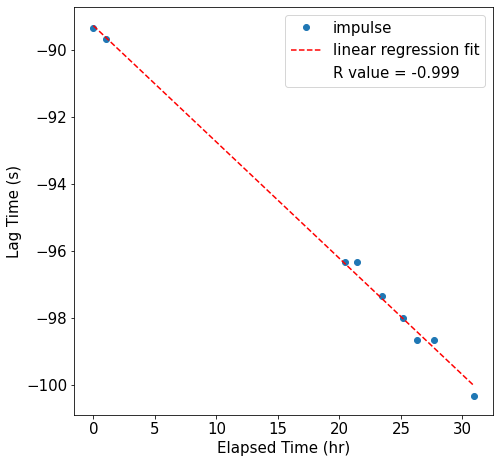

-0.9985153824463862


In [25]:
instrument = 'Multistation CO2_1'
def linregr(df):
    from scipy import stats
    x  = np.array(df.dropna()['hrs_from_start'])
    y = np.array(df.dropna()['ave_lag'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return x,y,slope,intercept,r_value,p_value,std_err


fig,ax=plt.subplots(figsize=[7.5,7.5])

labsize = 15

x,y,slope,intercept,r_value,p_value,std_err = linregr(groups[instrument])

plt.plot(x, y, 'o', label='impulse')
plt.plot(x, intercept + slope*x, 'r--', label='linear regression fit')
ax.set_ylabel('Lag Time (s)',size=labsize)
ax.set_xlabel('Elapsed Time (hr)',size=labsize)
ax.plot([], [], ' ', label=f'R value = {round(r_value,3)}')


ax.tick_params(axis='both', which='major', labelsize=labsize)
ax.legend(fontsize = labsize)

plt.show()
print(r_value)

